# 0 准备工作

In [90]:
import time
import pandas as pd
import numpy as np
from autograd import grad, hessian
import matplotlib.pyplot as plt
from scipy.optimize import minimize

font = {'family': 'SimHei',
        'weight': 'bold',
        'size': '10'}
plt.rc('font', **font)
plt.rc('axes', unicode_minus=False)


def plot_optimize_path(func, point, path, func_name, method):
    x_coords = [p[0] for p in path]
    y_coords = [p[1] for p in path]
    x_min = min(x_coords) - 1
    x_max = max(x_coords) + 1
    y_min = min(y_coords) - 1
    y_max = max(y_coords) + 1
    x1 = np.linspace(x_min, x_max, 100)
    x2 = np.linspace(y_min, y_max, 100)
    var_1, var_2 = np.meshgrid(x1, x2)
    var_z = func([var_1, var_2])
    fig, ax = plt.subplots(figsize=(8, 6))
    cs = ax.contourf(var_1, var_2, var_z, levels=50, cmap='jet')
    ax.scatter(x_coords, y_coords, s=10, color='y', label='路径上的点')
    ax.plot(x_coords, y_coords, '-r', label='收敛路径')
    ax.scatter(point[0], point[1], s=250, marker='*', color='green', label='最优点')
    fig.colorbar(cs, ax=ax)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'使用{method}优化 {func_name} 函数')
    ax.legend()
    plt.show()


def normalize(vector):
    norm = np.linalg.norm(vector)
    if norm == 0:
        return vector
    return vector / norm


def rosenbrock(var):
    x, y = var
    result = (1 - x) ** 2 + 100 * (y - x ** 2) ** 2
    return result


def beale(var):
    x, y = var
    result = (1.5 - x + x * y) ** 2 + (2.25 - x + x * y ** 2) ** 2 + (2.625 - x + x * y ** 3) ** 2
    return result


def goldstein_price(var):
    x, y = var
    result = (1 + ((x + y + 1) ** 2) * (19 - 14 * x + 3 * x ** 2 - 14 * y + 6 * x * y + 3 * y ** 2)) * \
             (30 + (2 * x - 3 * y) ** 2 * (18 - 32 * x + 12 * x ** 2 + 48 * y - 36 * x * y + 27 * y ** 2))
    return result

# 1 最速下降算法
![](resources/最速下降算法.png)

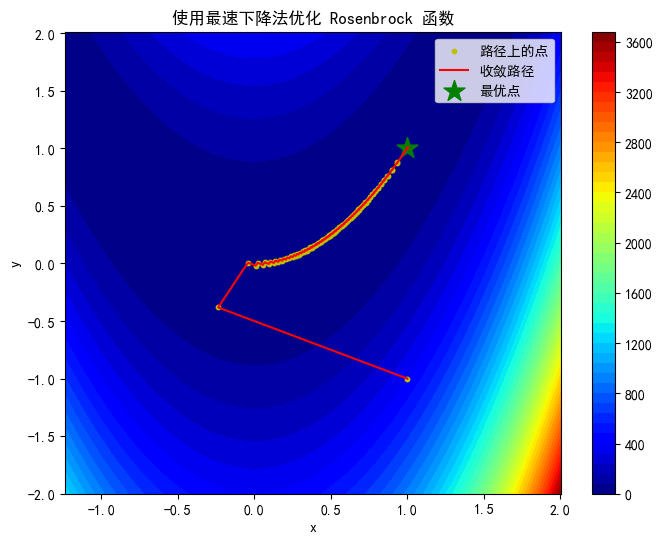

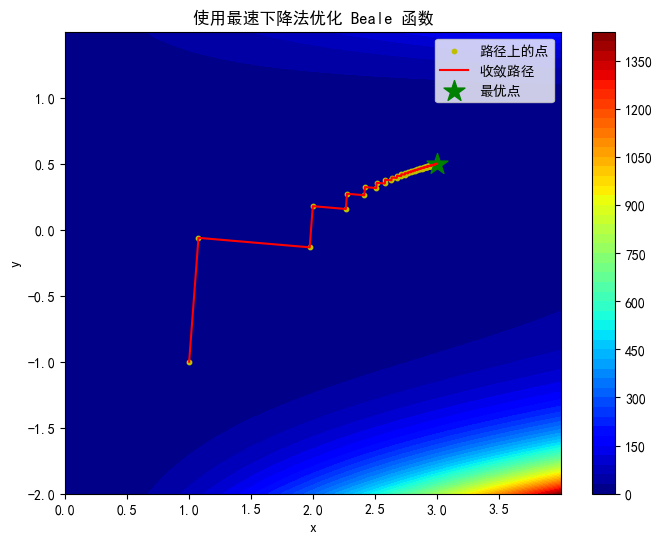

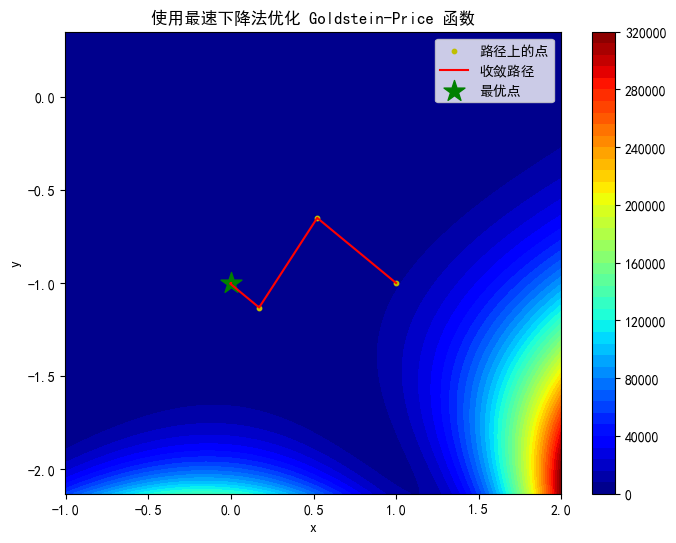

In [91]:
def steepest_descent(func, init_point, epsilon=1e-5, max_iter=1e6):
    def line_search_rosenbrock(var):
        x, y = x_k + var * d_k
        result = (1 - x) ** 2 + 100 * (y - x ** 2) ** 2
        return result

    def line_search_beale(var):
        x, y = x_k + var * d_k
        result = (1.5 - x + x * y) ** 2 + (2.25 - x + x * y ** 2) ** 2 + (2.625 - x + x * y ** 3) ** 2
        return result

    def line_search_goldstein_price(var):
        x, y = x_k + var * d_k
        result = (1 + ((x + y + 1) ** 2) * (19 - 14 * x + 3 * x ** 2 - 14 * y + 6 * x * y + 3 * y ** 2)) * \
                 (30 + (2 * x - 3 * y) ** 2 * (18 - 32 * x + 12 * x ** 2 + 48 * y - 36 * x * y + 27 * y ** 2))
        return result

    line_search_func = None
    if func is rosenbrock:
        line_search_func = line_search_rosenbrock
    elif func is beale:
        line_search_func = line_search_beale
    elif func is goldstein_price:
        line_search_func = line_search_goldstein_price
    grad_func = grad(func)
    x_k = np.array(init_point).astype(np.float64)
    d_k = -1 * normalize(grad_func(x_k))
    lambda_k = 1
    path = [x_k.copy()]
    for k in range(1, int(max_iter)):
        if np.array(abs(grad_func(x_k)) <= epsilon).all():
            return k, x_k, func(x_k), path
        else:
            res = minimize(line_search_func, lambda_k)
            lambda_k = res.x[0]
            x_k += lambda_k * d_k
            d_k = -1 * normalize(grad_func(x_k))
            path.append(x_k.copy())


func_dict = {'Rosenbrock': rosenbrock, 'Beale': beale, 'Goldstein-Price': goldstein_price}
steepest_descent_df = pd.DataFrame(
    columns=['Methods', 'Functions', 'Optimal Value', 'Iterations', 'Execution Time', 'Optimal Point'])
for key in func_dict.keys():
    tic = time.time()
    steps, opt_point, opt_f, opt_path = steepest_descent(func_dict[key], [1, -1])
    toc = time.time()
    t = round(toc - tic, 4)
    plot_optimize_path(func_dict[key], opt_point, opt_path, key, '最速下降法')
    steepest_descent_df.loc[len(steepest_descent_df)] = ['最速下降法', key, opt_f, steps, t, tuple(opt_point)]

In [92]:
steepest_descent_df

,Methods,Functions,Optimal Value,Iterations,Execution Time,Optimal Point
0,最速下降法,Rosenbrock,7.089354e-11,109,0.1863,"(1.0000084150699124, 1.0000168585190605)"
1,最速下降法,Beale,1.214739e-10,222,0.4921,"(2.999972453924435, 0.49999314138891626)"
2,最速下降法,Goldstein-Price,3.000000e+00,16,0.0620,"(-2.2755094953699314e-08, -1.0000000164230425)"


# 2 阻尼牛顿法
![](resources/阻尼牛顿法.png)

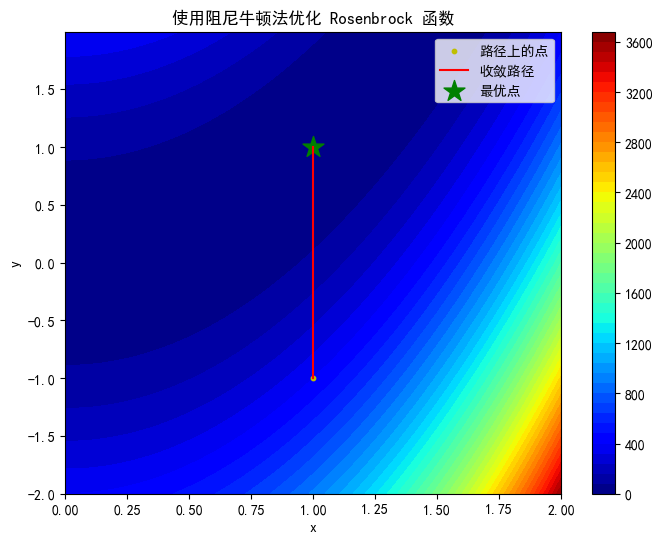

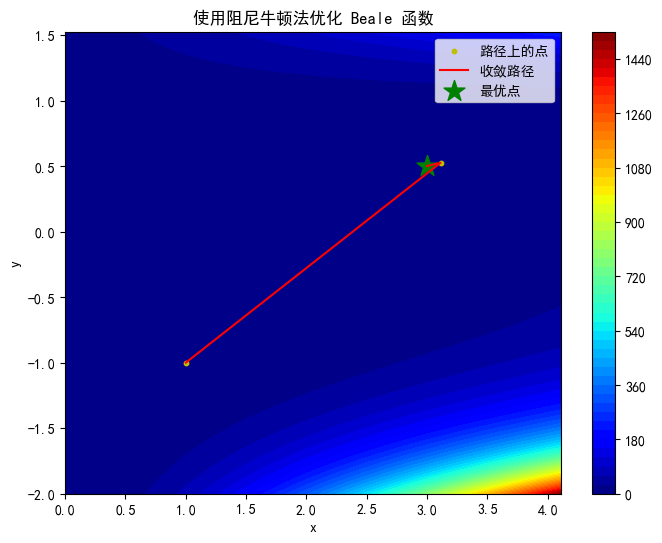

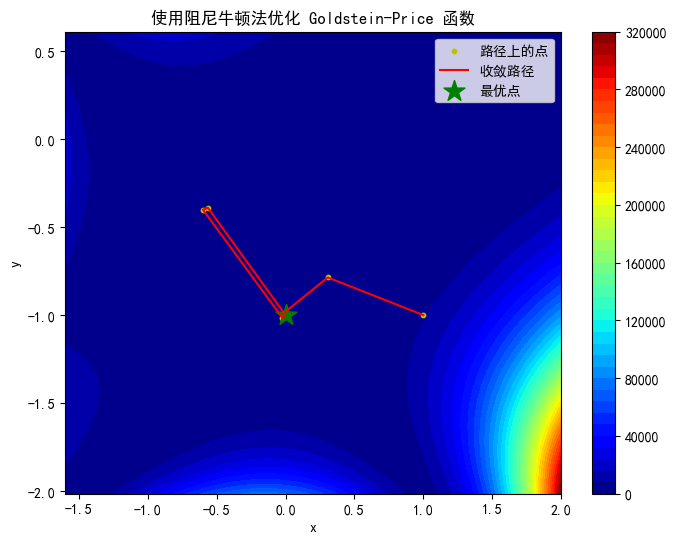

In [93]:
def damped_newton(func, init_point, epsilon=1e-4, max_iter=1e6):
    def line_search_rosenbrock(var):
        x, y = x_k + var * d_k
        result = (1 - x) ** 2 + 100 * (y - x ** 2) ** 2
        return result

    def line_search_beale(var):
        x, y = x_k + var * d_k
        result = (1.5 - x + x * y) ** 2 + (2.25 - x + x * y ** 2) ** 2 + (2.625 - x + x * y ** 3) ** 2
        return result

    def line_search_goldstein_price(var):
        x, y = x_k + var * d_k
        result = (1 + ((x + y + 1) ** 2) * (19 - 14 * x + 3 * x ** 2 - 14 * y + 6 * x * y + 3 * y ** 2)) * \
                 (30 + (2 * x - 3 * y) ** 2 * (18 - 32 * x + 12 * x ** 2 + 48 * y - 36 * x * y + 27 * y ** 2))
        return result

    line_search_func = None
    if func is rosenbrock:
        line_search_func = line_search_rosenbrock
    elif func is beale:
        line_search_func = line_search_beale
    elif func is goldstein_price:
        line_search_func = line_search_goldstein_price
    grad_func = grad(func)
    hesse_func = hessian(func)
    x_k = np.array(init_point).astype(np.float64)
    d_k = -1 * normalize(
        np.squeeze(np.array((np.matrix(hesse_func(x_k)).I * np.matrix(grad_func(x_k)).T).T).astype(np.float64)))
    lambda_k = 1
    path = [x_k.copy()]
    for k in range(1, int(max_iter)):
        if np.array(abs(grad_func(x_k)) <= epsilon).all():
            return k, x_k, func(x_k), path
        else:
            res = minimize(line_search_func, lambda_k)
            lambda_k = res.x[0]
            x_k += lambda_k * d_k
            d_k = -1 * normalize(
                np.squeeze(np.array((np.matrix(hesse_func(x_k)).I * np.matrix(grad_func(x_k)).T).T).astype(np.float64)))
            path.append(x_k.copy())


func_dict = {'Rosenbrock': rosenbrock, 'Beale': beale, 'Goldstein-Price': goldstein_price}
damped_newton_df = pd.DataFrame(
    columns=['Methods', 'Functions', 'Optimal Value', 'Iterations', 'Execution Time', 'Optimal Point'])
for key in func_dict.keys():
    tic = time.time()
    steps, opt_point, opt_f, opt_path = damped_newton(func_dict[key], [1, -1])
    toc = time.time()
    t = round(toc - tic, 4)
    plot_optimize_path(func_dict[key], opt_point, opt_path, key, '阻尼牛顿法')
    damped_newton_df.loc[len(damped_newton_df)] = ['阻尼牛顿法', key, opt_f, steps, t, tuple(opt_point)]

In [94]:
damped_newton_df

,Methods,Functions,Optimal Value,Iterations,Execution Time,Optimal Point
0,阻尼牛顿法,Rosenbrock,5.581937e-15,2,0.0052,"(1.0000000000000002, 0.9999999925287641)"
1,阻尼牛顿法,Beale,8.812137e-10,4,0.0239,"(3.000070281592509, 0.5000154445120302)"
2,阻尼牛顿法,Goldstein-Price,3.000000e+00,8,0.0826,"(-9.138640776210012e-09, -0.9999999902118183)"


# 3 BFGS方法
![](resources/BFGS.png)


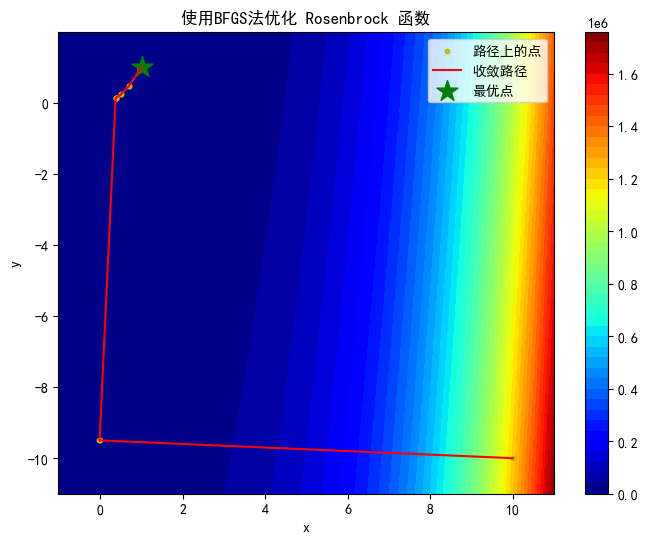

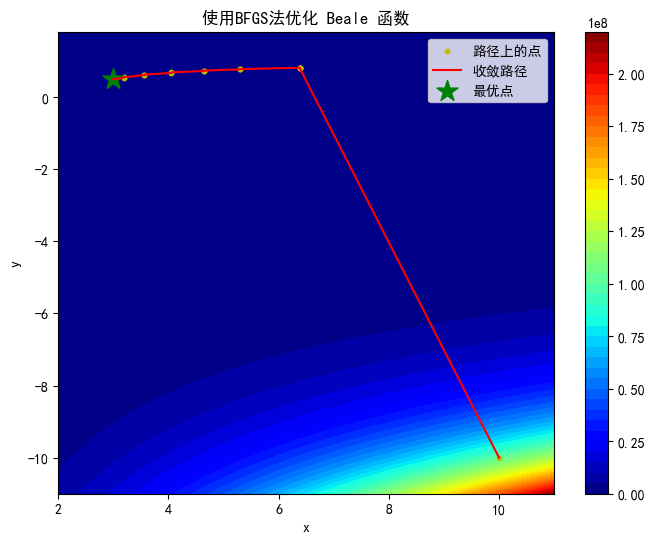

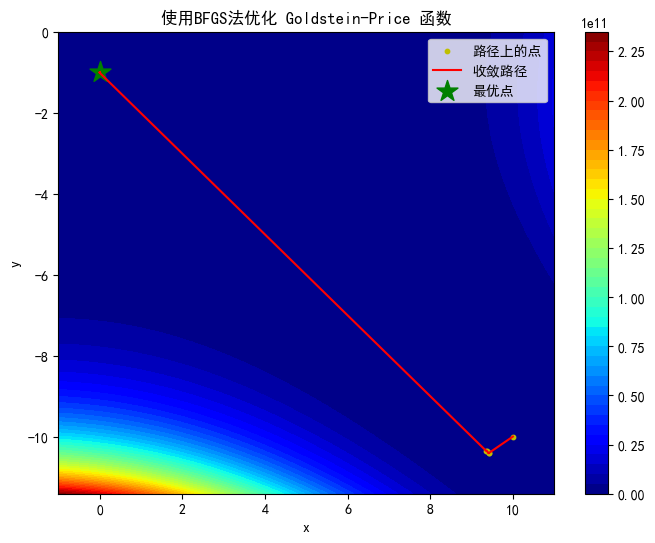

In [95]:
def bfgs(func, init_point, epsilon=1e-4, max_iter=1e6):
    def line_search_rosenbrock(var):
        x, y = x_k + var * d_k
        result = (1 - x) ** 2 + 100 * (y - x ** 2) ** 2
        return result

    def line_search_beale(var):
        x, y = x_k + var * d_k
        result = (1.5 - x + x * y) ** 2 + (2.25 - x + x * y ** 2) ** 2 + (2.625 - x + x * y ** 3) ** 2
        return result

    def line_search_goldstein_price(var):
        x, y = x_k + var * d_k
        result = (1 + ((x + y + 1) ** 2) * (19 - 14 * x + 3 * x ** 2 - 14 * y + 6 * x * y + 3 * y ** 2)) * \
                 (30 + (2 * x - 3 * y) ** 2 * (18 - 32 * x + 12 * x ** 2 + 48 * y - 36 * x * y + 27 * y ** 2))
        return result

    line_search_func = None
    if func is rosenbrock:
        line_search_func = line_search_rosenbrock
    elif func is beale:
        line_search_func = line_search_beale
    elif func is goldstein_price:
        line_search_func = line_search_goldstein_price

    grad_func = grad(func)
    x_k = np.array(init_point).astype(np.float64)
    lambda_k = 1
    path = [x_k.copy()]
    iters = 1
    for j in range(int(max_iter // 2)):
        b_k = np.matrix(np.eye(2))
        g_k = grad_func(x_k)
        d_k = -1 * normalize(np.squeeze(np.array((b_k * np.matrix(g_k).T).T).astype(np.float64)))
        for k in range(2):
            if np.array(abs(grad_func(x_k)) <= epsilon).all():
                return iters, x_k, func(x_k), path
            else:
                iters += 1
                res = minimize(line_search_func, lambda_k)
                lambda_k = res.x[0]
                x_k += lambda_k * d_k
                q_k = np.matrix(grad_func(x_k) - g_k).T
                p_k = np.matrix(lambda_k * d_k).T
                g_k = grad_func(x_k)
                b_k += (q_k * q_k.T) / (q_k.T * p_k) - (b_k * p_k * p_k.T * b_k) / (p_k.T * b_k * p_k)
                d_k = -1 * normalize(np.squeeze(np.array((b_k * np.matrix(grad_func(x_k)).T).T).astype(np.float64)))
                path.append(x_k.copy())


func_dict = {'Rosenbrock': rosenbrock, 'Beale': beale, 'Goldstein-Price': goldstein_price}
bfgs_df = pd.DataFrame(
    columns=['Methods', 'Functions', 'Optimal Value', 'Iterations', 'Execution Time', 'Optimal Point'])
for key in func_dict.keys():
    tic = time.time()
    steps, opt_point, opt_f, opt_path = bfgs(func_dict[key], [10, -10])
    toc = time.time()
    t = round(toc - tic, 4)
    plot_optimize_path(func_dict[key], opt_point, opt_path, key, 'BFGS法')
    bfgs_df.loc[len(bfgs_df)] = ['BFGS法', key, opt_f, steps, t, tuple(opt_point)]

In [96]:
bfgs_df

,Methods,Functions,Optimal Value,Iterations,Execution Time,Optimal Point
0,BFGS法,Rosenbrock,1.705622e-08,39,0.0970,"(0.9998694950477064, 0.9997385103405474)"
1,BFGS法,Beale,4.795829e-09,21,0.0901,"(2.9998269203369476, 0.49995704288365556)"
2,BFGS法,Goldstein-Price,3.000000e+00,18,0.1347,"(-6.34321256542948e-08, -0.9999999529879271)"
